In [275]:
import sys
import numpy as np
import pandas as pd
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt 
import networkx as nx
from scipy.spatial import Delaunay
from tqdm import tqdm 

In [276]:
df = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])
df = df[df['month']==12][['sourceid', 'dstid', 'mean_travel_time']]
# change start of movement id 1 -> 0
edges = df.sub([1, 1, 0])

In [277]:
vertices = []
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())
    for area in census_tracts['features']:
        # change start of movement id 1 -> 0
        id = int(area['properties']['MOVEMENT_ID']) - 1
        name = area['properties']['DISPLAY_NAME']
        a = area['geometry']['coordinates'][0]
        # considering polygon & multipolygon area types
        centloc = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)
        vertices.append([id, name, centloc])

vertices = np.array(vertices, dtype=object)
vertices = pd.DataFrame(vertices, columns=['id', 'display', 'centloc'])

In [278]:
g = ig.Graph.DataFrame(edges, directed=False, vertices=vertices)
gcc = g.clusters().giant()
gcc = gcc.simplify(combine_edges=dict(mean_travel_time='mean'))
print(len(gcc.vs), len(gcc.es))

2649 1003858


In [279]:
mst = gcc.spanning_tree(weights=gcc.es['mean_travel_time'])
for i, e in enumerate(mst.es):
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n'
        .format(np.linalg.norm(mst.vs[e.source]['centloc'] - mst.vs[e.target]['centloc'])* 69, e['mean_travel_time']))
    if i > 3:
        break

Distance in miles: 0.885
Time taken: 129.8

Distance in miles: 0.570
Time taken: 118.3

Distance in miles: 0.447
Time taken: 90.2

Distance in miles: 0.621
Time taken: 126.5

Distance in miles: 0.812
Time taken: 125.7



In [280]:
# traingle inequality
N = 1000
counter = 0
i = 0
while i < N:
    points = np.random.randint(1, high=len(gcc.vs), size=3)
    try:
        e1, e2, e3 = gcc.get_eid(points[0], points[1]), gcc.get_eid(points[1], points[2]), gcc.get_eid(points[2], points[0])
        w1, w2, w3 = gcc.es['mean_travel_time'][e1], gcc.es['mean_travel_time'][e2], gcc.es['mean_travel_time'][e3]       
    except: continue
    i += 1
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
        counter += 1
print(counter / N)

0.907


In [281]:
def preorderTraversal(g, root): 
    stack = []
    preorder =[] 
    preorder.append(root) 
    stack.append(root) 
    while len(stack)>0:
        flag = 0
        if g.vs[stack[-1]].degree(mode='OUT') == 0: 
            stack.pop() 
        else: 
            par = stack[-1]
        for child in g.vs[par].neighbors(mode='OUT'): 
            if child.index not in preorder: 
                flag = 1
                stack.append(child.index) 
                preorder.append(child.index) 
                break
        if flag == 0: 
            stack.pop() 
    return preorder

In [282]:
def twoApprox(root): 
    pre = preorderTraversal(mst, root)
    pre.append(root)
    cost_approx = 0
    final_path = [root]
    for i in range(len(pre) - 1):
        eid = gcc.get_eid(pre[i], pre[i+1], directed=False, error=False)
        if eid != -1:
            cost_approx += gcc.es[eid]['mean_travel_time']
            final_path.append(pre[i+1])
        else:
            cost_approx += (gcc.shortest_paths(pre[i], pre[i+1], weights='mean_travel_time'))[0][0]
            path = gcc.get_shortest_paths(pre[i], pre[i+1], weights='mean_travel_time', output='vpath')
            for ind in path[0][1:]:
                final_path.append(ind)
    return cost_approx, final_path

In [283]:
cost_mst = sum(mst.es['mean_travel_time'])
cost_approx_min = sys.maxsize
path_approx = []
count = 0
points = np.random.randint(1, high=len(gcc.vs), size=30)
for point in tqdm(points):
    cost, path = twoApprox(point)
    if cost < cost_approx_min:
        cost_approx_min = cost
        path_approx = path
        count += 1

upper = cost_approx_min / cost_mst
print(cost_mst)
print(cost_approx_min)
print(upper)

100%|██████████| 30/30 [01:26<00:00,  2.90s/it]

269084.5449999994
455368.86499999947
1.6922891836838883


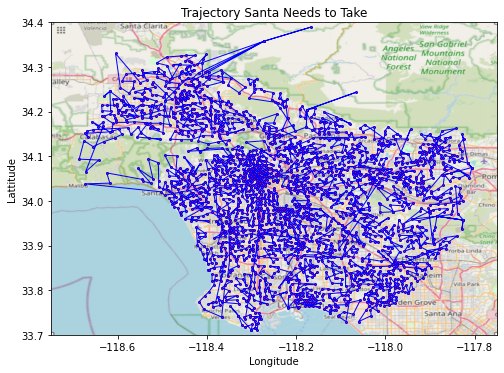

In [284]:
loc_x = [gcc.vs[i]['centloc'][0] for i in path_approx]
loc_y = [gcc.vs[i]['centloc'][1] for i in path_approx]
bbox = ((-118.75, -117.75, 33.7, 34.4))
la_map = plt.imread('la.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(loc_x, loc_y, color='blue', marker='o', linewidth=1, markersize=2, markerfacecolor='red')
ax.set_title('Trajectory Santa Needs to Take')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
# plt.savefig('Q10b.png', dpi=300, bbox_inches='tight')
plt.show()

In [246]:
# vertices & edges dataframe api
df_es = gcc.get_edge_dataframe()
df_vs = gcc.get_vertex_dataframe()
df_es['source'].replace(df_vs['name'], inplace=True)
df_es['target'].replace(df_vs['name'], inplace=True)
df_vs.head()

,name,display,centloc
vertex ID,,,
0,0,Census Tract 480302,"[-118.12053321311474, 34.103095573770496]"
1,1,Census Tract 480303,"[-118.13785063157897, 34.09645121052631]"
2,2,Census Tract 480304,"[-118.13138209090911, 34.09626386363636]"
3,3,Census Tract 480400,"[-118.13224544444446, 34.10349303174603]"
4,4,Census Tract 480500,"[-118.14492316666666, 34.098681500000005]"
